Objective of the notbook.
1. Getting the skeleton right.
2. unction for train and test losses
3. Train and Test Loaders and transforms

Output
*   Model Parameters: 195,352
*   Best Train Accuracy: 99.31%
*   Best Test Accuracy: 98.87%



In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
!pip install torchsummary
from torchsummary import summary
import matplotlib.pyplot as plt

In [0]:
# Create the data reader and transformer
train_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))])
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.1307,), (0.3081,))])


In [0]:
train = datasets.MNIST('./data',
                       train=True,
                       transform = train_transform,
                       download = True)
test = datasets.MNIST('./data',
                       train=False,
                       transform = test_transform,
                       download = True)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [0]:
# Set seed for all the environments
SEED = 1
torch.manual_seed(SEED)

CUDA = torch.cuda.is_available()
print("CUDA is available:",CUDA)
# If CUDA is available the set SEED for it
if CUDA:
    torch.cuda.manual_seed(SEED)


CUDA is available: True


In [0]:
# DATA LOADER
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if CUDA else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train,**dataloader_args)
# test dataloader
test_loader = torch.utils.data.DataLoader(test,**dataloader_args)

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


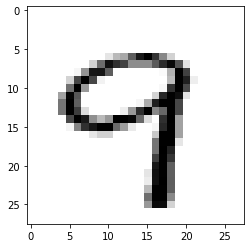

In [0]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

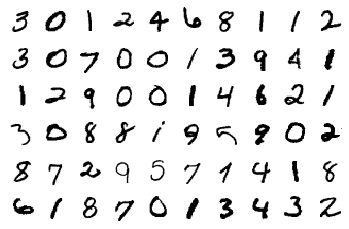

In [0]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [0]:
# The MODEL

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1) #input -? OUtput? RF
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(256, 512, 3)
        self.conv6 = nn.Conv2d(512, 1024, 3)
        self.conv7 = nn.Conv2d(1024, 10, 3)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = F.relu(self.conv6(F.relu(self.conv5(x))))
        # x = F.relu(self.conv7(x))
        x = self.conv7(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # FIRST LAYER
        self.conv_block_1 = nn.Sequential(nn.Conv2d(in_channels = 1,
                                      out_channels = 32,
                                      kernel_size=3, 
                                      stride = 1,
                                      padding=0,
                                      bias=True
                                      ),                                         #output size = 26 Receptive field = 3
                                      nn.ReLU()
        )
        
        # CONVOLUTION BLOCK
        self.conv_block_2 = nn.Sequential(nn.Conv2d(in_channels=32,
                                                    out_channels=64,
                                                    kernel_size=3,
                                                    stride=1,
                                                    padding=0,
                                                    bias = True),                #Output Size = 24, Receptive Field = 5
                                          nn.ReLU()
        ) 
        self.conv_block_3 = nn.Sequential(nn.Conv2d(in_channels=64,
                                                    out_channels=128,
                                                    kernel_size=3,
                                                    stride=1,
                                                    padding=0,
                                                    bias = True),                #Output size = 22 Receptive field = 7
                                          nn.ReLU()
        )
        
        # TRANSITION BLOCK
        self.pool_1 = nn.MaxPool2d(kernel_size=2,stride=2,padding=0)             #  #Output size = 11 Receptive field = 8
        self.conv_block_4 = nn.Sequential(nn.Conv2d(in_channels=128,
                                                    out_channels=32,
                                                    kernel_size=1,
                                                    stride=1,
                                                    padding=0,
                                                    bias = True),                #Output size = 11 Receptive field = 10
                                          nn.ReLU()
        )

        # CONVOLUTION BLOCK
        self.conv_block_5 = nn.Sequential(nn.Conv2d(in_channels=32,
                                                    out_channels=64,
                                                    kernel_size=3,
                                                    stride=1,
                                                    padding=0,
                                                    bias = True),                #Output size = 9 Receptive field = 14
                                          nn.ReLU()
        )
        self.conv_block_6 = nn.Sequential(nn.Conv2d(in_channels=64,
                                                    out_channels=128,
                                                    kernel_size=3,
                                                    stride=1,
                                                    padding=0,
                                                    bias = True),                #Output size = 7 Receptive field = 16
                                          nn.ReLU()
        )

        # OUTPUT LAYER
        self.conv_block_7 = nn.Sequential(nn.Conv2d(in_channels=128,
                                                    out_channels=10,
                                                    kernel_size=1,
                                                    stride=1,
                                                    padding=0,
                                                    bias = True),                #Output size = 7 Receptive field = 18
                                          nn.ReLU()
        )
        self.conv_block_8 = nn.Sequential(nn.Conv2d(in_channels=10,
                                                    out_channels=10,
                                                    kernel_size=7,
                                                    stride=1,
                                                    padding=0,
                                                    bias = True)                 #Output size = 1 Receptive field = 24
        ) 

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.pool_1(x)
        x = self.conv_block_4(x)
        x = self.conv_block_5(x)
        x = self.conv_block_6(x)
        x = self.conv_block_7(x)
        x = self.conv_block_8(x)
        print(x.shape)
        x = x.view(-1, 10)
        final_x = F.log_softmax(x, dim=-1)
        return final_x

In [0]:
device = torch.device("cuda" if CUDA else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
torch.Size([2, 10, 1, 1])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
              ReLU-3           [-1, 64, 24, 24]               0
            Conv2d-4          [-1, 128, 22, 22]          73,856
              ReLU-5          [-1, 128, 22, 22]               0
         MaxPool2d-6          [-1, 128, 11, 11]               0
            Conv2d-7           [-1, 32, 11, 11]           4,128
              ReLU-8           [-1, 32, 11, 11]               0
            Conv2d-9             [-1, 64, 9, 9]          18,496
             ReLU-10             [-1, 64, 9, 9]               0
           Conv2d-11            [-1, 128, 7, 7]          73,856
             ReLU-12            [-1, 128, 7, 7]               0
           Conv2d-13             [-1, 10, 7, 7]           1,290
        

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [0]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.1684604436159134 Batch_id=468 Accuracy=60.77: 100%|██████████| 469/469 [00:12<00:00, 36.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1593, Accuracy: 9511/10000 (95.11%)

EPOCH: 1


Loss=0.12696164846420288 Batch_id=468 Accuracy=95.84: 100%|██████████| 469/469 [00:12<00:00, 41.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0910, Accuracy: 9703/10000 (97.03%)

EPOCH: 2


Loss=0.04797542095184326 Batch_id=468 Accuracy=97.35: 100%|██████████| 469/469 [00:12<00:00, 37.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0709, Accuracy: 9777/10000 (97.77%)

EPOCH: 3


Loss=0.06562798470258713 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:12<00:00, 37.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0572, Accuracy: 9823/10000 (98.23%)

EPOCH: 4


Loss=0.022623321041464806 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:12<00:00, 36.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0465, Accuracy: 9854/10000 (98.54%)

EPOCH: 5


Loss=0.0244685560464859 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:13<00:00, 35.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0429, Accuracy: 9863/10000 (98.63%)

EPOCH: 6


Loss=0.13242702186107635 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:12<00:00, 37.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0596, Accuracy: 9815/10000 (98.15%)

EPOCH: 7


Loss=0.005327671766281128 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:12<00:00, 36.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0352, Accuracy: 9885/10000 (98.85%)

EPOCH: 8


Loss=0.07207426428794861 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:12<00:00, 44.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0362, Accuracy: 9882/10000 (98.82%)

EPOCH: 9


Loss=0.006738712545484304 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:13<00:00, 35.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0349, Accuracy: 9900/10000 (99.00%)

EPOCH: 10


Loss=0.013955389149487019 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:12<00:00, 36.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0340, Accuracy: 9895/10000 (98.95%)

EPOCH: 11


Loss=0.0010496278991922736 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:12<00:00, 36.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0391, Accuracy: 9870/10000 (98.70%)

EPOCH: 12


Loss=0.0018940767040476203 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:12<00:00, 37.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0532, Accuracy: 9836/10000 (98.36%)

EPOCH: 13


Loss=0.03198036178946495 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:12<00:00, 36.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0388, Accuracy: 9880/10000 (98.80%)

EPOCH: 14


Loss=0.003744686720892787 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:12<00:00, 36.85it/s]



Test set: Average loss: 0.0344, Accuracy: 9887/10000 (98.87%)



Text(0.5, 1.0, 'Test Accuracy')

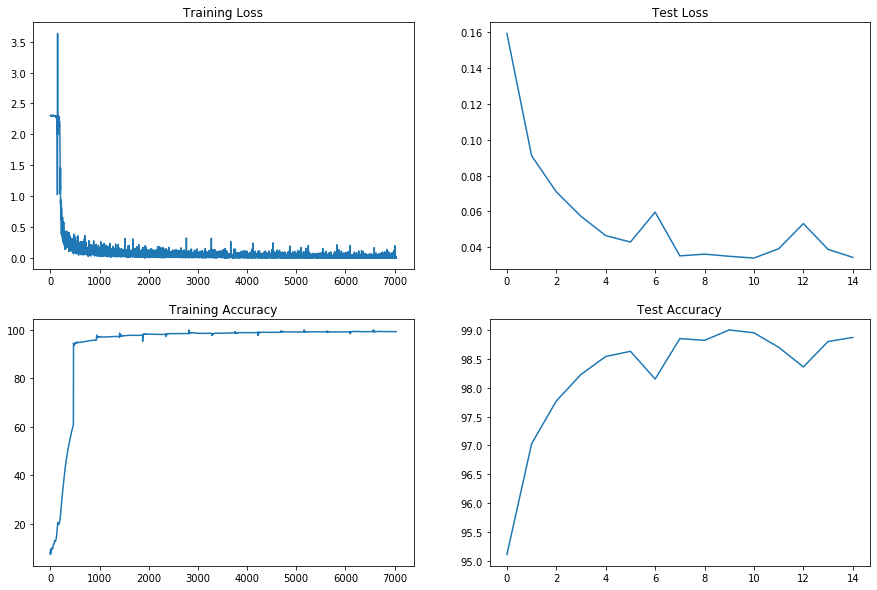

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")